# Section 1.2: Self-Attention Profiling: Computational Complexity Analysis



## Setup and Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import resource, psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')
from torch.utils.flop_counter import FlopCounterMode
import tracemalloc
from tabulate import tabulate
import io
import contextlib


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Self-Attention Implementation

In [ ]:
class SelfAttention(nn.Module):
    """Self-Attention mechanism implementation"""

    def __init__(self, d_model: int, d_k: int = None, d_v: int = None):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_k if d_k else d_model
        self.d_v = d_v if d_v else d_model


        self.W_q = nn.Linear(d_model, self.d_k)
        self.W_k = nn.Linear(d_model, self.d_k)
        self.W_v = nn.Linear(d_model, self.d_v)
        self.W_o = nn.Linear(self.d_v, d_model)

        self.s = self.d_k ** 0.5

    def forward(self, x: torch.Tensor):
        """
        Forward pass
        """
        batch_size, seq_len, _ = x.size()


        Q = self.W_q(x)  # (batch_size, seq_len, d_k)
        K = self.W_k(x)  # (batch_size, seq_len, d_k)
        V = self.W_v(x)  # (batch_size, seq_len, d_v)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.s  # (batch_size, seq_len, seq_len)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)  # (batch_size, seq_len, d_v)
        output = self.W_o(output)

        return output

model = SelfAttention(d_model=64)
x = torch.randn(2, 10, 64)
with torch.no_grad():
    output = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])


## FLOPS, Memory, and Performance Measurement Functions

In [ ]:
def count_flops(model: nn.Module, input_tensor: torch.Tensor):
    """
    Count FLOPs using PyTorch's FlopCounterMode.
    """
    training = model.training
    model.eval()
    with FlopCounterMode(model, display=False) as flop_counter:
        with torch.no_grad():
            _ = model(input_tensor)
    flops = int(flop_counter.get_total_flops())
    if training:
        model.train()
    return flops

def cpu_peak_rss_mb_during(fn):
    """
    return peak RSS delta (MB) via resource.getrusage.
    """
    r0 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    fn()
    r1 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    diff = max(0, r1 - r0)
    if diff > 10**8:
        return diff / (1024**2)
    else:
        return diff / 1024.0

def mean_se(vals):
    vals = np.asarray(vals, dtype=np.float64)
    avg = float(vals.mean())
    stde = float((vals.std(ddof=1) / np.sqrt(len(vals))) if len(vals) > 1 else 0.0)
    return avg, stde

def profile_self_attention(
    seq_len: int,
    d_model: int = 512,
    batch_size: int = 1,
    device: str = 'cpu',
    num_runs: int = 10,
):
    model = SelfAttention(d_model).to(device)
    x = torch.randn(batch_size, seq_len, d_model, device=device)


    with torch.no_grad():
        for _ in range(3):
            _ = model(x)
    if device == 'cuda':
        torch.cuda.synchronize()


    flop_samples = []
    time_samples_ms = []
    peak_mem_samples_mb = []

    for _ in range(num_runs):

        flop_samples.append(float(count_flops(model, x)))

        if device == 'cuda':
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.synchronize()

        t0 = time.perf_counter()
        with torch.no_grad():
            y = model(x)
        if device == 'cuda':
            torch.cuda.synchronize()
        t1 = time.perf_counter()
        time_samples_ms.append((t1 - t0) * 1000.0)

        if device == 'cuda':
            peak_mb = torch.cuda.max_memory_allocated(device=device) / (1024**2)
        else:

            peak_mb = cpu_peak_rss_mb_during(lambda: model(x).detach())
        peak_mem_samples_mb.append(peak_mb)

        del y

    flops_mean, flops_se = mean_se(flop_samples)
    time_mean, time_se = mean_se(time_samples_ms)
    mem_mean, mem_se = mean_se(peak_mem_samples_mb)

    return (
        flops_mean, flops_se,
        mem_mean,  mem_se,
        time_mean, time_se
    )

## Run Profiling Experiment


In [5]:
seq_lengths = [10, 100, 1000, 10000]
d_model = 512
batch_size = 1
num_runs = 20

print("Self-Attention Profiling Experiment")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU only'}")

results = {
    'cpu': {'seq_lengths': [], 'flops': [], 'flops_se': [], 'memory': [], 'memory_se': [], 'time': [], 'time_se': []},
    'gpu': {'seq_lengths': [], 'flops': [], 'flops_se': [], 'memory': [], 'memory_se': [], 'time': [], 'time_se': []}
}

cuda_available = torch.cuda.is_available()

for seq_len in seq_lengths:
    print(f"\nsequence length: {seq_len}")

    (cpu_flops, cpu_flops_se,
     cpu_mem,  cpu_mem_se,
     cpu_time, cpu_time_se) = profile_self_attention(
        seq_len, d_model, batch_size, 'cpu', num_runs
    )
    results['cpu']['seq_lengths'].append(seq_len)
    results['cpu']['flops'].append(cpu_flops)
    results['cpu']['flops_se'].append(cpu_flops_se)
    results['cpu']['memory'].append(cpu_mem)
    results['cpu']['memory_se'].append(cpu_mem_se)
    results['cpu']['time'].append(cpu_time)
    results['cpu']['time_se'].append(cpu_time_se)
    print(f"  CPU - Time: {cpu_time:.2f}ms ± {cpu_time_se:.2f}ms | "
          f"Mem: {cpu_mem:.2f}MB ± {cpu_mem_se:.2f}MB | "
          f"FLOPs: {cpu_flops:.3g} ± {cpu_flops_se:.3g}")

    if cuda_available:
        (gpu_flops, gpu_flops_se,
         gpu_mem,  gpu_mem_se,
         gpu_time, gpu_time_se) = profile_self_attention(
            seq_len, d_model, batch_size, 'cuda', num_runs
        )
        results['gpu']['seq_lengths'].append(seq_len)
        results['gpu']['flops'].append(gpu_flops)
        results['gpu']['flops_se'].append(gpu_flops_se)
        results['gpu']['memory'].append(gpu_mem)
        results['gpu']['memory_se'].append(gpu_mem_se)
        results['gpu']['time'].append(gpu_time)
        results['gpu']['time_se'].append(gpu_time_se)
        print(f"  GPU - Time: {gpu_time:.2f}ms ± {gpu_time_se:.2f}ms | "
              f"Mem: {gpu_mem:.2f}MB ± {gpu_mem_se:.2f}MB | "
              f"FLOPs: {gpu_flops:.3g} ± {gpu_flops_se:.3g}")
    else:
        print("  GPU not available")

Self-Attention Profiling Experiment
Device: CUDA

sequence length: 10
  CPU - Time: 0.39ms ± 0.01ms | Mem: 0.00MB ± 0.00MB | FLOPs: 2.12e+07 ± 0
  GPU - Time: 0.39ms ± 0.01ms | Mem: 13.25MB ± 0.00MB | FLOPs: 2.12e+07 ± 0

sequence length: 100
  CPU - Time: 1.71ms ± 0.02ms | Mem: 0.06MB ± 0.03MB | FLOPs: 2.3e+08 ± 0
  GPU - Time: 0.59ms ± 0.02ms | Mem: 14.38MB ± 0.00MB | FLOPs: 2.3e+08 ± 0

sequence length: 1000
  CPU - Time: 14.63ms ± 0.18ms | Mem: 0.48MB ± 0.31MB | FLOPs: 4.15e+09 ± 0
  GPU - Time: 0.62ms ± 0.01ms | Mem: 32.73MB ± 0.00MB | FLOPs: 4.15e+09 ± 0

sequence length: 10000
  CPU - Time: 529.09ms ± 17.01ms | Mem: 6.84MB ± 3.81MB | FLOPs: 2.26e+11 ± 0
  GPU - Time: 14.77ms ± 0.35ms | Mem: 897.13MB ± 0.00MB | FLOPs: 2.26e+11 ± 0


## Results Visualization

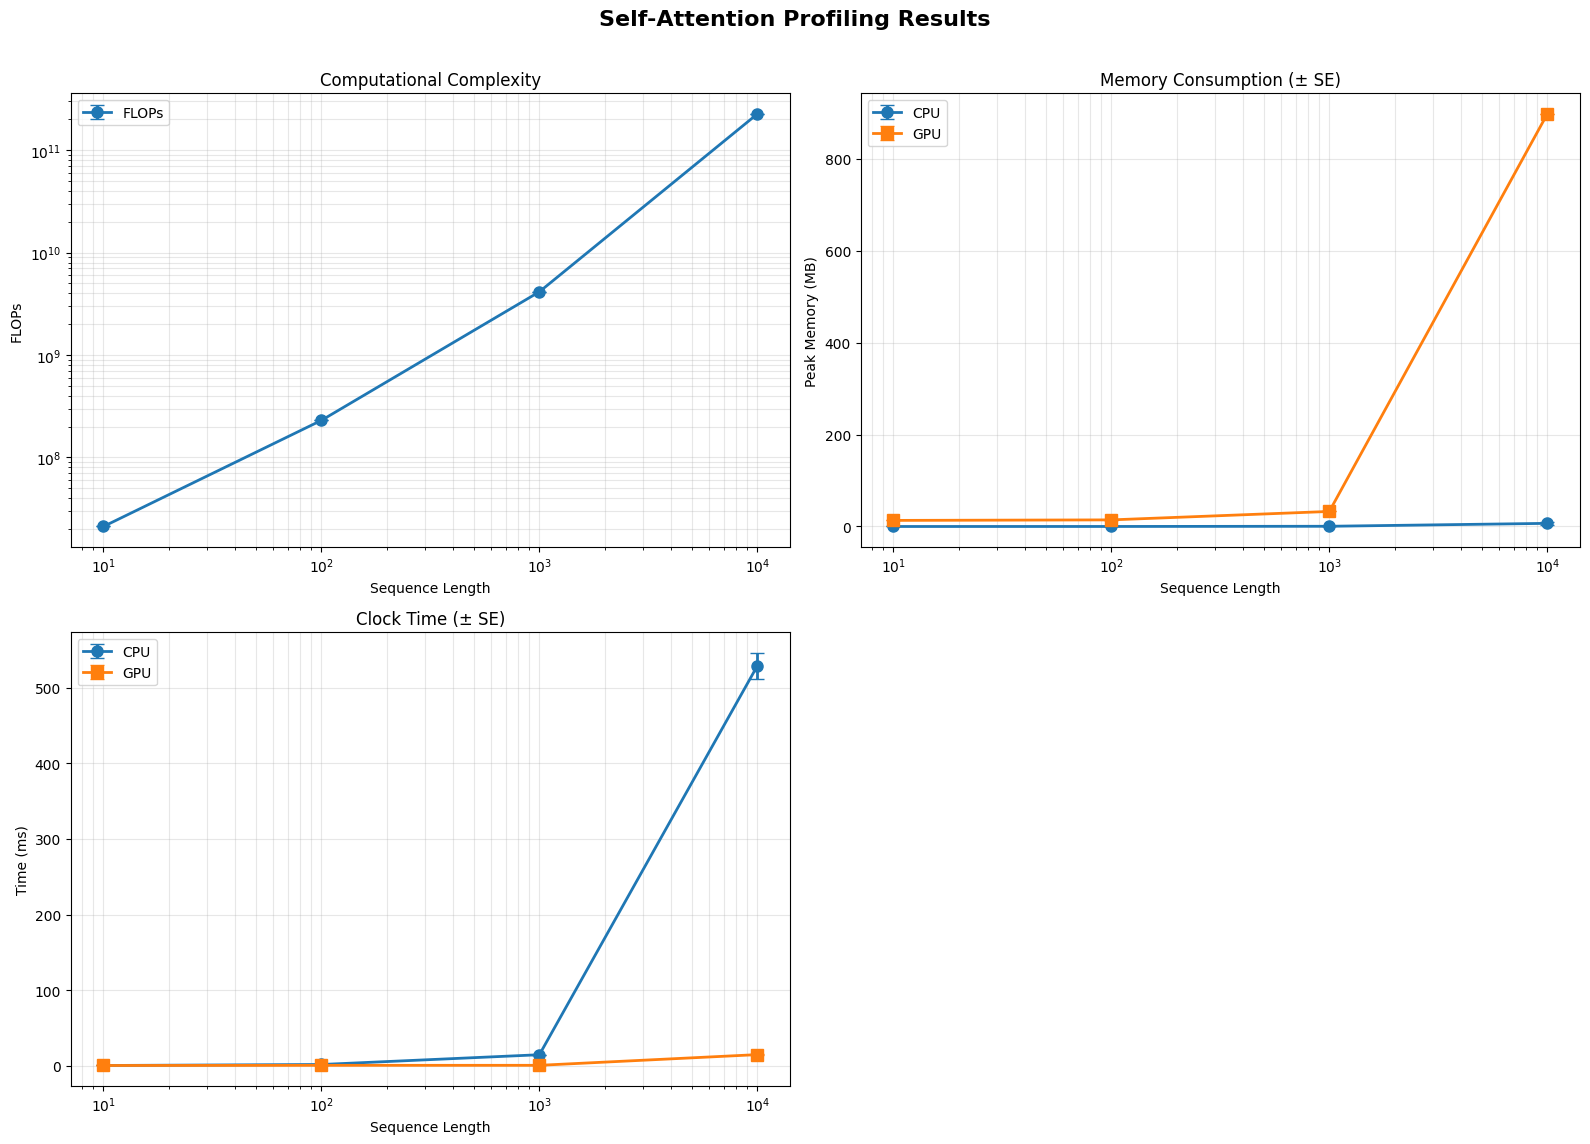

In [11]:
import os
os.makedirs('results', exist_ok=True)
def _get(arr, fallback=None):
    return arr if arr is not None else fallback

def create_plots(results):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Self-Attention Profiling Results', fontsize=16, fontweight='bold')

    ax1 = axes[0, 0]
    src = 'cpu' if results['cpu']['seq_lengths'] else 'gpu'
    seqs = results[src]['seq_lengths']
    flops = results[src]['flops']
    flops_se = results[src].get('flops_se', None)
    if flops_se is not None:
        ax1.errorbar(seqs, flops, yerr=flops_se, fmt='o-', linewidth=2, markersize=8,
                     capsize=5, label='FLOPs')
    else:
        ax1.loglog(seqs, flops, 'o-', linewidth=2, markersize=8, label='FLOPs')
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set_xlabel('Sequence Length'); ax1.set_ylabel('FLOPs')
    ax1.set_title('Computational Complexity')
    ax1.grid(True, which='both', alpha=0.3); ax1.legend()

    ax2 = axes[0, 1]
    if results['cpu']['seq_lengths']:
        ax2.errorbar(results['cpu']['seq_lengths'],
                     results['cpu']['memory'],
                     yerr=results['cpu'].get('memory_se', None),
                     fmt='o-', linewidth=2, markersize=8, capsize=5, label='CPU')
    if results['gpu']['seq_lengths']:
        ax2.errorbar(results['gpu']['seq_lengths'],
                     results['gpu']['memory'],
                     yerr=results['gpu'].get('memory_se', None),
                     fmt='s-', linewidth=2, markersize=8, capsize=5, label='GPU')
    ax2.set_xscale('log')
    ax2.set_xlabel('Sequence Length'); ax2.set_ylabel('Peak Memory (MB)')
    ax2.set_title('Memory Consumption (± SE)')
    ax2.grid(True, which='both', alpha=0.3); ax2.legend()

    ax3 = axes[1, 0]
    if results['cpu']['seq_lengths']:
        ax3.errorbar(results['cpu']['seq_lengths'],
                     results['cpu']['time'],
                     yerr=results['cpu'].get('time_se', results['cpu'].get('time_se', None)),
                     fmt='o-', linewidth=2, markersize=8, capsize=5, label='CPU')
    if results['gpu']['seq_lengths']:
        ax3.errorbar(results['gpu']['seq_lengths'],
                     results['gpu']['time'],
                     yerr=results['gpu'].get('time_se', results['gpu'].get('time_se', None)),
                     fmt='s-', linewidth=2, markersize=8, capsize=5, label='GPU')
    ax3.set_xscale('log')
    ax3.set_xlabel('Sequence Length'); ax3.set_ylabel('Time (ms)')
    ax3.set_title('Clock Time (± SE)')
    ax3.grid(True, which='both', alpha=0.3); ax3.legend()
    axes[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig('results/self_attention_profiling_results.png')
    plt.show()


create_plots(results)

In [12]:
from google.colab import files


files.download('results/self_attention_profiling_results.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Interpretation:

FLOPs:
The curve rises quadratically with
sequence length. This is what we expected for training vanilla self-attention: computing the n×n attention matrix dominates cost. The log–log line is nearly straight with slope ≈2.

Peak memory:
GPU memory jumps dramatically when we have 10k token, reflecting storage of attention logits/weights and activations that scale as O(n^2). CPU appears almost flat in terms of growth since it is processing the attention computation sequentially and can therefore free memories on the way. 

Wall-clock time:
CPU time explodes between 1k and 10k within seconds, while GPU grows much more flatly, This is consistent with the GPU’s massive parallelism and higher memory bandwidth. The curvature again suggests approximatly n^2 scaling of computational cost.